# 1. Movie Prediction

In [1]:
import process_data
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
import warnings
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The method "predict_by_all" is designed for using all rating features to train the machine learning models(SVM, Logistic Regression and Naive Bayes). Firstly we normalize the features and also split into training and test parts. Finally using test data to test the accuracy of models, and return the scores of models.

In [2]:
def predict_by_all(df, X_list):
    # df is the dataframe with all rating features and 'profit' feature
    # X_list is the list of features of dataframe
    X = df[X_list]
    y = df['profit']

    # Normalize each features
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    # Data split
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5)

    #SVM Classifier
    svc_model = SVC(kernel='linear', C=21)
    svc_model.fit(x_train, y_train)    
    SVC_score = svc_model.score(x_test, y_test)

    #Logistic Regression
    LR_model = LogisticRegression()
    LR_model.fit(x_train, y_train)
    LR_score = LR_model.score(x_test, y_test)

    NB_model = GaussianNB()
    NB_model.fit(x_train, y_train)
    NB_score = NB_model.score(x_test, y_test)

    return SVC_score, LR_score, NB_score

The method "feature_selection" is responsible for evaluate the importance of features and select the top-2 important features. 
1. Using correlation of pearson method to calculate the pairwise correlation of features.
2. Normalize data
3. Using normalized data to train Random Forest model, and "feature_importances_" coefficient of random forest model to show the importance of features.
4. Finally select the top-2 features.

#### The figure and table showed below the function call.

In [3]:
def feature_selection(df, X_list):
    corr = df[X_list].corr()
    title = plt.axes()
    sb.heatmap(corr, cmap="Blues", annot=True, ax = title)
    title.set_title('The correlation of features with Pearson method')
    plt.xticks(rotation=15) 
#     plt.show()

    X = df[X_list].copy()
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    y = df['profit']

    forest = RandomForestClassifier()
    forest.fit(X, y)
    importances = forest.feature_importances_
    # print(importances)
    result = []
    print("The importance of features are: (sorted)")
    for k, v in sorted(zip(map(lambda x: round(x, 4), importances), X_list), reverse=True):
        print(v + ': ' + str(k))
        result.append((v, k))

    selected_list = []
    n = 2
    for i in range(n):
        selected_list.append(result[i][0])

    selected_list.append('profit')
    selected_df = df[selected_list]
    selected_df = selected_df.reset_index(drop=True)
    
    return selected_df

In [4]:
def feature_reduction(df, X_list):
    X = df[X_list]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    pca = PCA(2)
    pca.fit(X)
    X = pca.transform(X)

    index = ['x1', 'x2']
    pca_df = pd.DataFrame(X, columns=index)
    df = df.reset_index()
    pca_df['profit'] = df['profit']

    return pca_df

In [5]:
def predict_by_2x(df, normalized):
    X = df.iloc[:, 0:2]
    y = df.iloc[:, -1]
    if normalized == False:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)

    # Data split
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5)

    #SVM Classifier
    svc_model = SVC(kernel='linear', C=21)
    svc_model.fit(x_train, y_train)
    SVC_score = svc_model.score(x_test, y_test)

    #Logistic Regression
    LR_model = LogisticRegression()
    LR_model.fit(x_train, y_train)
    LR_score = LR_model.score(x_test, y_test)

    NB_model = GaussianNB()
    NB_model.fit(x_train, y_train)
    NB_score = NB_model.score(x_test, y_test)


    return SVC_score, LR_score, NB_score

In [6]:
wiki_movie_df = pd.read_json("wikidata-movies.json.gz", lines=True, encoding='UTF8')
rating_df = pd.read_json("rotten-tomatoes.json.gz", lines=True, encoding='UTF8')
genres_df = pd.read_json("omdb-data.json.gz", lines=True, encoding='UTF8')
wiki_genres_df = pd.read_json("genres.json.gz", lines=True, encoding='UTF8')    

In [7]:
wiki_movie_df = wiki_movie_df.set_index('imdb_id').join(rating_df.set_index('imdb_id'), \
                                                        how='left', \
                                                        lsuffix='wiki_movie_df')
wiki_movie_df = wiki_movie_df.reset_index()
info_list = ['audience_ratings',
                'audience_percent', 
                'audience_average', 
                'critic_percent', 
                'critic_average',
                'made_profit']

wiki_movie = wiki_movie_df[info_list].copy().reset_index(drop=True)

wiki_movie = wiki_movie[(wiki_movie.made_profit == 1.0) | (wiki_movie.made_profit == 0.0) ]

wiki_movie['profit'] = pd.Series(wiki_movie.made_profit == 1.0, index=wiki_movie.index)
wiki_movie = wiki_movie.drop(columns=['made_profit'])
wiki_movie = wiki_movie[wiki_movie.isnull().sum(axis=1) == 0].reset_index(drop=True)

X_list = ['audience_ratings',
            'audience_percent', 
            'audience_average', 
            'critic_percent', 
            'critic_average'
         ]
wiki_movie.head()

,audience_ratings,audience_percent,audience_average,critic_percent,critic_average,profit
0,4479.0,57.0,3.3,74.0,6.4,True
1,2421.0,60.0,3.4,76.0,7.0,True
2,26832.0,96.0,4.4,98.0,9.1,True
3,6801.0,57.0,3.4,89.0,7.3,True
4,39909.0,95.0,4.3,100.0,9.0,False


In [8]:
SVC_score_all, LR_score_all, NB_score_all = predict_by_all(wiki_movie, X_list)

The importance of features are: (sorted)
audience_ratings: 0.3451
critic_percent: 0.2131
audience_percent: 0.1734
critic_average: 0.1407
audience_average: 0.1276


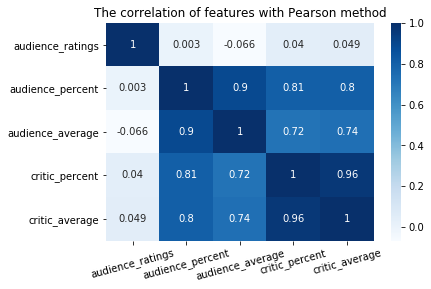

In [9]:
fs_df = feature_selection(wiki_movie, X_list)

In [10]:
fs_df.head()

,audience_ratings,critic_percent,profit
0,4479.0,74.0,True
1,2421.0,76.0,True
2,26832.0,98.0,True
3,6801.0,89.0,True
4,39909.0,100.0,False


In [11]:
pca_df = feature_reduction(wiki_movie, X_list)
pca_df.head()

,x1,x2,profit
0,0.336169,-0.104390,True
1,-0.082387,-0.102625,True
2,-3.160202,-0.240776,True
3,-0.351443,-0.058114,True
4,-3.037615,-0.213600,False


In [12]:
SVC_score_pca, LR_score_pca, NB_score_pca = predict_by_2x(pca_df, True)
SVC_score_fs, LR_score_fs, NB_score_fs = predict_by_2x(fs_df, False)

In [13]:
score_list = [
                SVC_score_all, LR_score_all, NB_score_all, \
                SVC_score_pca, LR_score_pca, NB_score_pca, \
                SVC_score_fs, LR_score_fs, NB_score_fs
            ]

method_list = [
                "The accuracy of model with all rating features by SVM Classifier",
                "The accuracy of model with all rating features by Logistic Regression",
                "The accuracy of model with all rating features by Naive bayes Classifier",
                "The accuracy of model with PCA transformed features by SVM Classifier",
                "The accuracy of model with PCA transformed features by Logistic Regression",
                "The accuracy of model with PCA transformed features by Naive Bayes Classifier",
                "The accuracy of model with Top-2 important features by SVM Classifier",
                "The accuracy of model with Top-2 important features by Logistic Regression",
                "The accuracy of model with Top-2 important features by Naive Bayes Classifier",
]

In [14]:
for k, v in sorted(zip(map(lambda x: round(x, 4), score_list), method_list), reverse=True):
    print(v + ': ' + str(k))

The accuracy of model with Top-2 important features by SVM Classifier: 0.856
The accuracy of model with Top-2 important features by Logistic Regression: 0.856
The accuracy of model with PCA transformed features by Logistic Regression: 0.8533
The accuracy of model with PCA transformed features by SVM Classifier: 0.8505
The accuracy of model with all rating features by Logistic Regression: 0.8424
The accuracy of model with all rating features by SVM Classifier: 0.8397
The accuracy of model with PCA transformed features by Naive Bayes Classifier: 0.6087
The accuracy of model with all rating features by Naive bayes Classifier: 0.5571
The accuracy of model with Top-2 important features by Naive Bayes Classifier: 0.3179
